In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.0.0-beta1
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
sklearn 0.20.3
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [4]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

In [5]:
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid))

W0714 18:19:09.061140 140736297124800 deprecation.py:323] From /Users/zhangyx/workspace/environments/tf2_py3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 118us/sample - loss: 0.5363 - accuracy: 0.8107 - val_loss: 0.4121 - val_accuracy: 0.8568
Epoch 2/10
55000/55000 [==============================] - 6s 114us/sample - loss: 0.3900 - accuracy: 0.8608 - val_loss: 0.3676 - val_accuracy: 0.8718
Epoch 3/10
55000/55000 [==============================] - 6s 109us/sample - loss: 0.3538 - accuracy: 0.8712 - val_loss: 0.3498 - val_accuracy: 0.8756
Epoch 4/10
55000/55000 [==============================] - 7s 120us/sample - loss: 0.3288 - accuracy: 0.8802 - val_loss: 0.3358 - val_accuracy: 0.8828
Epoch 5/10
55000/55000 [==============================] - 8s 139us/sample - loss: 0.3097 - accuracy: 0.8874 - val_loss: 0.3315 - val_accuracy: 0.8780
Epoch 6/10
55000/55000 [==============================] - 7s 122us/sample - loss: 0.2934 - accuracy: 0.8932 - val_loss: 0.3165 - val_accuracy: 0.8854
Epoch 7/10
55000/55000 [===========================

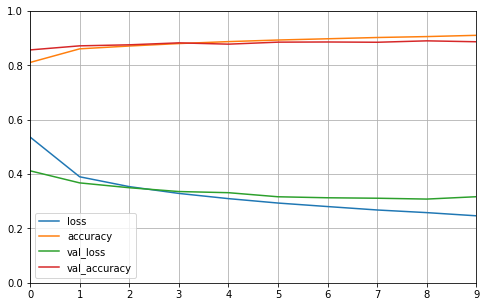

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [7]:
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 1s 62us/sample - loss: 0.3505 - accuracy: 0.8758


[0.35052303292751313, 0.8758]

In [8]:
tf.saved_model.save(model, "./keras_saved_graph")

In [9]:
!saved_model_cli show --dir ./keras_saved_graph --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['flatten_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28)
        name: serving_default_flatten_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


In [10]:
!saved_model_cli show --dir ./keras_saved_graph \
    --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['flatten_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28)
      name: serving_default_flatten_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [11]:
!saved_model_cli run --dir ./keras_saved_graph --tag_set serve \
    --signature_def serving_default \
    --input_exprs 'flatten_input=np.ones((2, 28, 28))'

2019-07-14 18:29:21.575412: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
W0714 18:29:21.576680 140736297124800 deprecation.py:323] From /Users/zhangyx/workspace/environments/tf2_py3/lib/python3.7/site-packages/tensorflow/python/tools/saved_model_cli.py:339: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W0714 18:29:21.633260 140736297124800 deprecation.py:323] From /Users/zhangyx/workspace/environments/tf2_py3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be remo

In [12]:
loaded_saved_model = tf.saved_model.load('./keras_saved_graph')
print(list(loaded_saved_model.signatures.keys()))

['serving_default']


In [13]:
inference = loaded_saved_model.signatures['serving_default']
print(inference)

In [14]:
print(inference.structured_outputs)

{'dense_2': TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_2')}


In [16]:
results = inference(tf.constant(x_test_scaled[0:1]))
print(results['dense_2'])

tf.Tensor(
[[7.4990585e-06 7.5836206e-06 5.3658046e-06 1.4856428e-06 2.8637976e-05
  1.4206698e-02 1.7013150e-05 2.4653120e-02 2.4786242e-04 9.6082473e-01]], shape=(1, 10), dtype=float32)
